In [2]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
from fastai import *
from fastai.tabular import *
from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [3]:
## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [4]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [ ]:
########################### Vars
#################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [ ]:
########################### Load Data
#################################################################################
print('Load Main Data')

# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv('/home/shanmugam/fastai/m5/sales_train_validation.csv')
prices_df = pd.read_csv('/home/shanmugam/fastai/m5/sell_prices.csv')
calendar_df = pd.read_csv('/home/shanmugam/fastai/m5/calendar.csv')

In [ ]:
########################### Make Grid
#################################################################################
print('Create Grid')

# We can tranform horizontal representation 
# to vertical "view"
# Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
# and labels are 'd_' coulmns

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

# If we look on train_df we se that 
# we don't have a lot of traning rows
# but each day can provide more train data
print('Train rows:', len(train_df), len(grid_df))

# To be able to make predictions
# we need to add "test set" to our grid
add_grid = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid = pd.concat([add_grid,temp_df])

grid_df = pd.concat([grid_df,add_grid])
grid_df = grid_df.reset_index(drop=True)

# Remove some temoprary DFs
del temp_df, add_grid

# We will not need original train_df
# anymore and can remove it
del train_df

# You don't have to use df = df construction
# you can use inplace=True instead.
# like this
# grid_df.reset_index(drop=True, inplace=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# We can free some memory 
# by converting "strings" to categorical
# it will not affect merging and 
# we will not lose any valuable data
for col in index_columns:
    grid_df[col] = grid_df[col].astype('category')

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

In [ ]:
########################### Product Release date
#################################################################################
print('Release week')

# It seems that leadings zero values
# in each train_df item row
# are not real 0 sales but mean
# absence for the item in the store
# we can safe some memory by removing
# such zeros

# Prices are set by week
# so it we will have not very accurate release week 
release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id','item_id','release']

# Now we can merge release_df
grid_df = merge_by_concat(grid_df, release_df, ['store_id','item_id'])
del release_df

# We want to remove some "zeros" rows
# from grid_df 
# to do it we need wm_yr_wk column
# let's merge partly calendar_df to have it
grid_df = merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])
                      
# Now we can cutoff some rows 
# and safe memory 
grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
grid_df = grid_df.reset_index(drop=True)

# Let's check our memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# Should we keep release week 
# as one of the features?
# Only good CV can give the answer.
# Let's minify the release values.
# Min transformation will not help here 
# as int16 -> Integer (-32768 to 32767)
# and our grid_df['release'].max() serves for int16
# but we have have an idea how to transform 
# other columns in case we will need it
grid_df['release'] = grid_df['release'] - grid_df['release'].min()
grid_df['release'] = grid_df['release'].astype(np.int16)

# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

In [ ]:
########################### Save part 1
#################################################################################
print('Save Part 1')

# We have our BASE grid ready
# and can save it as pickle file
# for future use (model training)
grid_df.to_pickle('grid_part_1.pkl')

print('Size:', grid_df.shape)

In [ ]:
########################### Prices
#################################################################################
print('Prices')

# We can do some basic aggregations
prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

# and do price normalization (min/max scaling)
prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

# Some items are can be inflation dependent
# and some items are very "stable"
prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

# I would like some "rolling" aggregations
# but would like months and years as "window"
calendar_prices = calendar_df[['wm_yr_wk','month','year']]
calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
del calendar_prices

# Now we can add price "momentum" (some sort of)
# Shifted by week 
# by month mean
# by year mean
prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

del prices_df['month'], prices_df['year']

In [ ]:
grid_df = reduce_mem_usage(grid_df)
prices_df = reduce_mem_usage(prices_df)

In [ ]:
########################### Merge prices and save part 2
#################################################################################
print('Merge prices and save part 2')

# Merge Prices
original_columns = list(grid_df)
grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
keep_columns = [col for col in list(grid_df) if col not in original_columns]
grid_df = grid_df[MAIN_INDEX+keep_columns]
grid_df = reduce_mem_usage(grid_df)

# Safe part 2
grid_df.to_pickle('grid_part_2.pkl')
print('Size:', grid_df.shape)

# We don't need prices_df anymore
del prices_df

# We can remove new columns
# or just load part_1
grid_df = pd.read_pickle('grid_part_1.pkl')

In [ ]:
########################### Merge calendar
#################################################################################
grid_df = grid_df[MAIN_INDEX]

# Merge calendar partly
icols = ['date',
         'd',
         'event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']

grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')

# Minify data
# 'snap_' columns we can convert to bool or int8
icols = ['event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']
for col in icols:
    grid_df[col] = grid_df[col].astype('category')

# Convert to DateTime
grid_df['date'] = pd.to_datetime(grid_df['date'])

# Make some features from date
grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8)
grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8)
grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8)
grid_df['tm_y'] = grid_df['date'].dt.year
grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8)
grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8)

grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8)
grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8)

# Remove date
#del grid_df['date']

In [ ]:
########################### Save part 3 (Dates)
#################################################################################
print('Save part 3')

# Safe part 3
grid_df.to_pickle('grid_part_3.pkl')
print('Size:', grid_df.shape)

# We don't need calendar_df anymore
del calendar_df
del grid_df

In [ ]:
########################### Some additional cleaning
#################################################################################

## Part 1
# Convert 'd' to int
grid_df = pd.read_pickle('grid_part_1.pkl')
grid_df['d'] = grid_df['d'].apply(lambda x: x[2:]).astype(np.int16)

# Remove 'wm_yr_wk'
# as test values are not in train set
del grid_df['wm_yr_wk']
grid_df.to_pickle('grid_part_1.pkl')

del grid_df

In [ ]:
########################### Summary
#################################################################################

# Now we have 3 sets of features
grid_df = pd.concat([pd.read_pickle('grid_part_1.pkl'),
                     pd.read_pickle('grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle('grid_part_3.pkl').iloc[:,2:]],
                     axis=1)
                     
# Let's check again memory usage
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
print('Size:', grid_df.shape)

# 2.5GiB + is is still too big to train our model
# (on kaggle with its memory limits)
# and we don't have lag features yet
# But what if we can train by state_id or shop_id?
state_id = 'CA'
grid_df = grid_df[grid_df['state_id']==state_id]
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
#           Full Grid:   1.2GiB

store_id = 'CA_1'
grid_df = grid_df[grid_df['store_id']==store_id]
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
#           Full Grid: 321.2MiB

# Seems its good enough now
# In other kernel we will talk about LAGS features
# Thank you.

In [ ]:
########################### Final list of features
#################################################################################
grid_df = pd.concat([pd.read_pickle('grid_part_1.pkl'),
                     pd.read_pickle('grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle('grid_part_3.pkl').iloc[:,2:]],
                     axis=1)
grid_df.info()

In [ ]:
grid_df = reduce_mem_usage(grid_df)

In [ ]:
grid_df.info()

In [ ]:
grid_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')

In [5]:
grid_df = pd.read_pickle('grid_df143.pkl')
grid_df = reduce_mem_usage(grid_df)

Mem. usage decreased to 1293.97 Mb (0.0% reduction)


In [5]:
features = list(grid_df.columns)


In [6]:
features = [
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'd',
 'release',
 'sell_price',
 'price_max',
 'price_min',
 'price_std',
 'price_mean',
 'price_norm',
 'price_nunique',
 'item_nunique',
 'price_momentum',
 'price_momentum_m',
 'price_momentum_y',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'tm_d',
 'tm_w',
 'tm_m',
 'tm_y',
 'tm_wm',
 'tm_dw',
 'tm_w_end',
'sales']

In [7]:
cat_m = ['snap_WI', 'snap_TX', 'snap_CA', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
        'tm_d','tm_w','tm_m','tm_y','tm_wm','tm_dw','tm_w_end', 'd']
cont = [x for x in features if x not in cat_m]
# cont = []
procs = [Categorify]

cont

['release',
 'sell_price',
 'price_max',
 'price_min',
 'price_std',
 'price_mean',
 'price_norm',
 'price_nunique',
 'item_nunique',
 'price_momentum',
 'price_momentum_m',
 'price_momentum_y',
 'sales']

In [8]:
df = grid_df[cont].copy()
df = df.astype('float32', errors='ignore')
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
def fix_missing(df, col, name, na_dict):
    
    if is_numeric_dtype(col):
        
        if pd.isnull(col).sum() or (name in na_dict):
                df[name+'_na'] = pd.isnull(col)
                filler = na_dict[name] if name in na_dict else col.median()
                df[name] = col.fillna(filler)
                na_dict[name] = filler
    return na_dict
na_dict = {}
na_dict_initial = na_dict.copy()
for n,c in df.items():
    na_dict = fix_missing(df, c, n, na_dict)
df.drop([a + '_na' for a in list(set(na_dict.keys())) ], axis=1, inplace=True)
na_dict
means,stds = {},{}
cont.remove('sales')
for n in cont:
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])
grid_df.drop(cont, axis=1, inplace=True)
for c in cont:
    grid_df[cont] = df[cont]
grid_df = reduce_mem_usage(grid_df)
del df
gc.collect()


Mem. usage decreased to 1295.30 Mb (55.4% reduction)


20

In [10]:
grid_df['sales'] = grid_df.sales.fillna(0.0)

In [11]:
grid_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,event_name_1,...,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1155,0.0,2014-03-28,NaN,...,1.492188,1.451172,0.074524,1.223633,0.550293,0.184204,-0.968750,0.661621,0.106750,1.091797
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1155,0.0,2014-03-28,NaN,...,-0.067261,0.120850,-0.635254,-0.033356,1.072266,-0.909180,0.876953,0.661621,0.106750,1.091797
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1155,0.0,2014-03-28,NaN,...,-0.345459,-0.189331,-0.635254,-0.324463,1.072266,-0.909180,0.686523,0.661621,0.106750,1.091797
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1155,2.0,2014-03-28,NaN,...,0.119019,0.235352,0.042633,0.128662,1.072266,-0.362549,-1.012695,0.661621,0.594238,1.091797
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1155,1.0,2014-03-28,NaN,...,-0.314941,-0.341553,0.065430,-0.333008,1.072266,0.730957,-0.954102,0.661621,0.763672,1.292969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23388952,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1941,0.0,2016-05-22,NaN,...,-0.342773,-0.341553,0.165771,-0.373779,1.072266,1.277344,1.975586,0.661621,0.742676,1.236328
23388953,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1941,0.0,2016-05-22,NaN,...,-0.426270,-0.490479,0.546387,-0.458984,0.789062,0.730957,0.935547,0.661621,0.043182,1.816406
23388954,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,0.0,2016-05-22,NaN,...,0.046234,0.123901,0.244873,0.009270,0.726074,0.184204,1.155273,0.661621,-0.634766,1.091797
23388955,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,0.0,2016-05-22,NaN,...,-0.815430,-0.713867,-0.635254,-0.816406,1.072266,-0.909180,-0.397461,0.661621,0.106750,1.091797


In [12]:
path = '/home/shanmugam/fastai/m5'
bs = 256
tab_db = (TabularList.from_df(grid_df, cat_names=cat_m, cont_names=cont, procs=procs, path=path)
#                             .split_by_idxs(train_idx=list(range(0,47373650)),valid_idx=list(range(47373650,48227369)))
                            .split_by_idx(list(range(21681517,22535237)))
                            .label_from_df(cols='sales')
                             .add_test((TabularList.from_df(grid_df.iloc[22535237:].copy(), cat_names=cat_m, cont_names=cont, path=path, procs=procs)), label=0)
                            .databunch(bs=bs, num_workers=1))

In [13]:
sub = grid_df.iloc[22535237:].copy()
del grid_df

In [16]:
?tabular_learner

In [17]:
learn = tabular_learner(tab_db, layers=[1000,500], metrics=rmse, ps=[0.001,0.01], emb_drop=0.04)

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


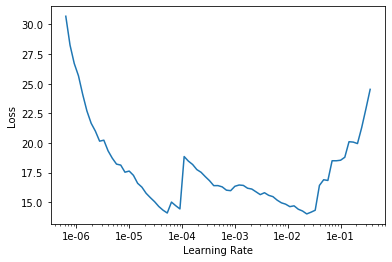

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit(1, 1e-05)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,7.693470,17.131300,3.152077,24:12


In [21]:
preds, _ = learn.get_preds(DatasetType.Test)

In [31]:
learn.callback_fns.

<function list.index(value, start=0, stop=9223372036854775807, /)>

In [22]:
y = preds.squeeze().tolist()
y

[-0.03797925263643265,
 0.05904652923345566,
 -0.1695878505706787,
 0.9986572861671448,
 0.1614953875541687,
 0.010784462094306946,
 -0.019554011523723602,
 0.8582507967948914,
 0.20656219124794006,
 -0.20753541588783264,
 -0.05346430093050003,
 -0.054746128618717194,
 -0.18423578143119812,
 0.4432402551174164,
 1.0308067798614502,
 0.9051096439361572,
 0.01572582870721817,
 0.11733124405145645,
 0.7153828740119934,
 0.17082712054252625,
 0.19324588775634766,
 0.013149142265319824,
 -0.26814329624176025,
 0.17961126565933228,
 0.2967551648616791,
 0.34653133153915405,
 0.39339005947113037,
 0.3892109990119934,
 0.2592180371284485,
 0.6039471626281738,
 0.056727536022663116,
 0.47435396909713745,
 0.23848861455917358,
 -0.11582378298044205,
 -0.4054129123687744,
 -0.4721883535385132,
 0.28564661741256714,
 0.10354916751384735,
 0.02061154693365097,
 0.37444743514060974,
 0.12224002182483673,
 0.10355448722839355,
 0.6007475256919861,
 -0.32800233364105225,
 0.08124806731939316,
 0.12501

In [23]:
INPUT_DIR = "/home/shanmugam/fastai/m5"
submission = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv").pipe(
        reduce_mem_usage
    )

Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [24]:
sub['demand'] = y
predictions = sub[['id', 'date', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.to_csv('submission_p.csv', index = False)